# Rendre floue une photographie

Le flou dans une photographie peut résulter de nombreuses cause: flou de défocalisation, flou de bougé de l'appareil ou des objets dans la scène... Ce tutoriel permet de simuler le flou et de comprendre son utilité.
Par la suite, la transformation d'une image sera parfois appelée filtre.

## Objectifs

A la fin de ce tutoriel, vous saurez:
1. Appliquer un filtre moyenneur et un filtre gaussien à une image.
2. Calculer à la main le résultat d'une interpolation bilinéaire.
3. Appliquer une matrice de convolution correspondant aux filtres moyenneur et laplacien.

In [10]:
# chargement des modules python
%matplotlib inline
import skimage
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import scipy.signal as signal

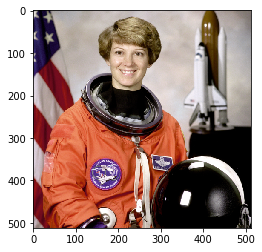

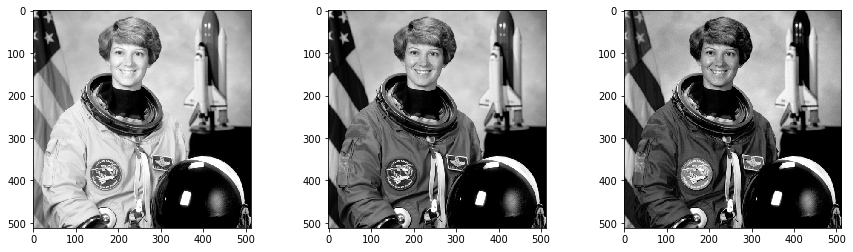

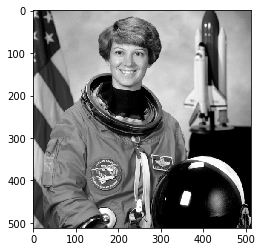

In [11]:
I = skimage.data.astronaut()
plt.imshow(I, cmap=plt.cm.gray)

I=I.astype(np.float)
Irouge=I[:,:,0]
Ivert=I[:,:,1]
Ibleu=I[:,:,2]
Indg=(Irouge+Ivert+Ibleu)/3
Indg=Indg.astype(np.uint8)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(Irouge, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(Ivert, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(Ibleu, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

plt.imshow(Indg, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.show()

## Fonctions classiques

Nous allons utiliser les fonctions ``uniform_filter`` et ``gaussian_filter`` de ``scipy.ndimage``.

### Filtres moyenneur

La fonction ``ndi.uniform_filter `` calcule la moyenne de toutes les valeurs dans un voisinage autour de chaque pixel. La taille de ce voisinage est donnée par le paramètre ``size``. Plus il est important, plus l'image sera perçue comme floue.

### Filtre Gaussien

La fonction ``ndi.gaussian_filter`` calcule une moyenne pondérée de toutes les pixels dans un voisinage autour du pixel considéré. La pondération suit une loi gaussienne, les coefficients décroissent à mesures qu'ils s'éloignent du pixel central. Cela permet de donner plus de poids à celui-ci. Ce filtre est intéressant car il est l'équivalent numérique de la défocalisation optique.
Le paramètre $\sigma$ (``sigma``) permet de contrôler la décroissance en fonction de l'éloignement: plus sa valeur est grande, plus l'image filtrée sera floue.

### Filtre médian

La fonction ``ndi.median_filter `` calcule la médiane de toutes les valeurs dans un voisinage autour de chaque pixel. La taille de ce voisinage est donnée par le paramètre ``size``. Plus il est important, plus l'image sera perçue comme floue. Mais contrairement au filtre moyenneur, le filtre médian conserve les contours.

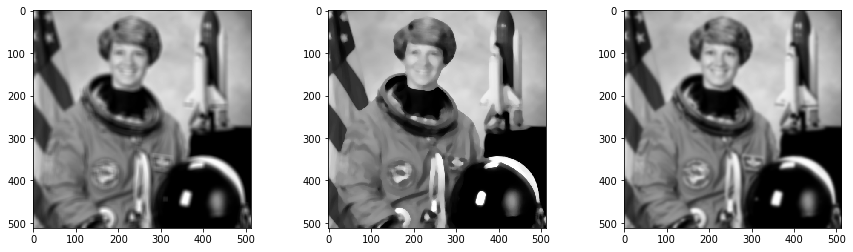

In [12]:
moyen = ndi.uniform_filter(Indg, size=11)
median = ndi.median_filter(Indg, size=11)
gaussian = ndi.gaussian_filter(Indg, sigma=3)

plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(moyen, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(median, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(gaussian, cmap=plt.cm.gray)
plt.show()

## Convolution

### Filtres moyenneur et Gaussien

Le flou gaussien est approximé par l'utilisation du masque de convolution suivant:

$$h=\frac{1}{16}\left[\begin{matrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{matrix}\right]$$

Sans entrer dans les détails, le masque de convolution s'écrit selon la formule suivante, en fonction de $\sigma$ (sigma), et des indices $i$ et $j$ dans le tableau, et de la taille $2*s+1$ ($s$ indique le *rayon* de voisinage):
$$h(i,j) =  \frac{1}{K} \exp\left(-\frac{(i-s)^2 + (j-s)^2}{2\sigma^2}\right)$$
avec $K$ un coefficient de normalisation qui permet de considérer que la somme des coefficients est 1.

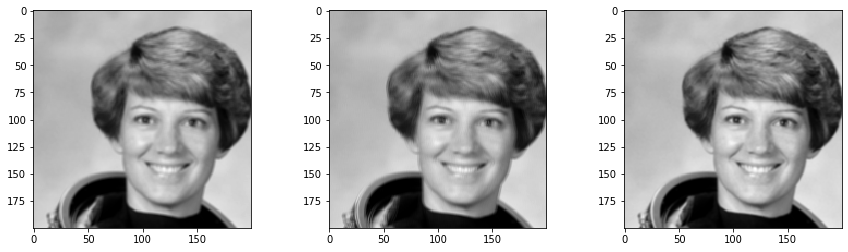

In [13]:
g=1/6 * np.array([[1,0,1], [1,0,1], [1,0,1]])
Iconvol=signal.convolve2d(Indg, g, 'same')

h = 1/16 * np.array([[1,2,1], [2,4,2], [1,2,1]])
#h= 1/?? * np.array([[1,4,7,4,1], [4,20,33,20,4], [7,33,55,33,7], [4,20,33,20,4], [1,4,7,4,1]]) # pour un filtre gaussien 5x5
gaussian2 = signal.convolve2d(Indg, h, 'same')

k = 1/9 * np.array([[1,1,1], [1,1,1], [1,1,1]])
#k= 1/25 * np.array([[1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1], [1,1,1,1,1]]) # pour un filtre moyen 5x5
moyen2 = signal.convolve2d(Indg, k, 'same')

# les masques sont de petites tailles
# pour voir le flou, on zoome sur une partie de l'image
# (plus le masque est grand, plus le flou est important)
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(moyen2[0:200,100:300], cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(132)
plt.imshow(Iconvol[0:200,100:300], cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(133)
plt.imshow(gaussian2[0:200,100:300], cmap=plt.cm.gray)
plt.show()

## Pour aller plus loin : créer sa fonction convolution

Dans un premier temps, nous allons générer un tableau de valeurs aléatoires. Le calcul va se faire de tête, ou en tous cas sans utiliser le langage python.
Rappel: l'origine dans un tableau est la valeur en haut à gauche. La première coordonnée représente l'indice de colonne, la seconde l'indice de ligne. Nous allons considérer le tableau suivant:

$$\left[\begin{matrix}
6 & 0 & 1 \\
0 & 0 & 0 \\
4 & 0 & 4
\end{matrix}\right]$$

1. Prenons la valeur aux coordonnées (1,1): c'est un 0.
2. Dans son voisinage, il y a les valeurs 6, 0, 1, puis 0 et 0, et enfin 4, 0 et 4
3. Si je calcule la moyenne de toutes ces valeurs, j'obtiens: $(6+0+1 + 0+0+0 + 4+0+4)/9 = 15/9 \approx 1.667$

### Calculez, pour chaque pixel, la valeur de la moyenne pour un voisinage de 9 pixels pris autour du pixel central
* Il faut considérer que lorsque le voisinage *sort* du tableau, les valeurs à l'extérieur sont nulles.

In [14]:
np.random.seed(0)
X = 2
Y = 2
A = np.random.randint(1, 10, size=(X,Y))
B = np.zeros((2*X, 2*Y))
B[::2, ::2] = A
print(B)

[[6. 0. 1. 0.]
 [0. 0. 0. 0.]
 [4. 0. 4. 0.]
 [0. 0. 0. 0.]]


### Programmation de l'opération

L'algorithme consiste à parcourir tous les pixels de l'image (en faisant une double boucle *for*), et, pour chaque pixel, regarder tous ces voisins (à nouveau, avec une double boucle *for*) pour calculer la moyenne:

Dans le cas d'un voisinage de 9 pixels, on définit la taille $s=1$. Si l'image a une taille (en pixels) de X par Y, alors, l'algorithme s'écrit:
> Copier $I$ dans $I_2$
>
> Pour les valeurs de i allant de s à X-1-s:
>> Pour les valeurs de j allant de s à Y-1-s:
>>> $\textrm{somme}=0$
>>>
>>> Pour les valeurs de m allant de i-s à i+s:
>>>> Pour les valeurs de n allant de j-s à j+s:
>>>>> $\textrm{somme} = \textrm{somme} + I[i+m,j+n]$
>>>>>
>>>>> fin
>>>>
>>>> fin
>>>>
>>> $I_2[m,n] = \textrm{somme}/s^2$
>>>
>>> fin
>>
>> fin
>
> retourner $I_2$

### Attention, les bords ne sont pas traités, et sont laissés tels quels, pour simplifier ce code.
Pour traiter les bords, nous allons tout d'abord utiliser une fonction pour ajouter des 0 autour de l'image.
        

In [15]:
def filtrage_moyenneur(I, s):
    
    # Démarrage: on ajoute des 0 autour de l'image
    I = np.pad(I, ((s,s), ))
    X,Y = I.shape
    I2 = np.copy(I)
    for i in np.arange(s,X-s):
        for j in np.arange(s,Y-s):
            somme = 0
            for m in np.arange(-s, s+1):
                for n in np.arange(-s, s+1):
                    somme = somme + I[i+m, j+n]
            I2[i,j] = somme / (2*s+1)**2
            
    # On supprime les 0 en trop
    I2 = I2[s:-s, s:-s]
    return I2

print(B)
res = filtrage_moyenneur(B, 1)
print(res)


[[6. 0. 1. 0.]
 [0. 0. 0. 0.]
 [4. 0. 4. 0.]
 [0. 0. 0. 0.]]
[[0.66666667 0.77777778 0.11111111 0.11111111]
 [1.11111111 1.66666667 0.55555556 0.55555556]
 [0.44444444 0.88888889 0.44444444 0.44444444]
 [0.44444444 0.88888889 0.44444444 0.44444444]]


### Vérification du résultat

Nous allons numériquement vérifier le résultat: ceci se fait par l'opérateur de convolution. Pour calculer la moyenne, nous utilisons le tableau (appelé masque de convolution, ou parfois matrice de convolution) $$h=\frac{1}{9}\left[\begin{matrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1
\end{matrix}\right]$$

Ce tableau représente la pondération de chaque pixel: pour calculer la moyenne, l'intensité de chaque pixel comptera pour $\frac{1}{9}$ du total.


In [16]:
h = 1/9 * np.ones((3,3))
res= signal.convolve2d(B, h, 'same') # l'option same indique que le résultat a la même taille que le tableau d'origine
print(res)

[[0.66666667 0.77777778 0.11111111 0.11111111]
 [1.11111111 1.66666667 0.55555556 0.55555556]
 [0.44444444 0.88888889 0.44444444 0.44444444]
 [0.44444444 0.88888889 0.44444444 0.44444444]]


### Flou plus important

Pour obtenir de cette manière un flou plus important, il faut utiliser un masque de convolution plus grand. Si $S$ est la taille du masque (prendre un nombre impair), alors $h$ est un tableau de taille $s\times s$ avec des coefficients $\frac{1}{s^2}$.

1. Vérifiez que la somme des coefficients vaut 1.
2. Observez que les bords sont foncés: les valeurs en dehors de l'image sont considérées comme étant à 0, c'est-à-dire noires.

### Flou Gaussien

Programmez une fonction simple, qui prend en entrée les paramètres $s$ et $\sigma$, et qui retourne le tableau $h$ de taille $s\times s$.
$$h=\frac{1}{16}\left[\begin{matrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1
\end{matrix}\right]$$

Générez un masque de taille $s=11$, avec $\sigma=5$.

Testez différentes valeurs de tailles et de $\sigma$.

In [17]:
def masque_gaussien(s, sigma):
    h = np.zeros((2*s+1, 2*s+1))
    
    for i in range(2*s+1):
        for j in range(2*s+1):
            h[i,j] = np.exp(- ((i-s)**2 + (j-s)**2 ) / (2*sigma**2))
            
    K = np.sum(h) # normalisation
    h = h / K
    return h

h = masque_gaussien(1, 1)
print(h)

[[0.07511361 0.1238414  0.07511361]
 [0.1238414  0.20417996 0.1238414 ]
 [0.07511361 0.1238414  0.07511361]]


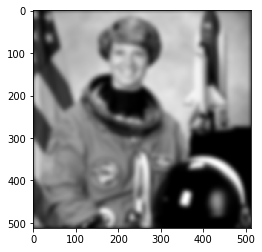

In [18]:
h = masque_gaussien(11, 5)
gaussian3 = signal.convolve2d(Indg, h, 'same')
plt.imshow(gaussian3, cmap=plt.cm.gray)
plt.show()